In [1]:
!pip install yfinance numpy pandas scikit-learn ta xgboost matplotlib seaborn tradingview_ta tradernet-sdk tradernet pandas_ta

     ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
     ---------------------------------------- 0.1/11.0 MB 2.0 MB/s eta 0:00:06
      --------------------------------------- 0.2/11.0 MB 2.9 MB/s eta 0:00:04
     -- ------------------------------------- 0.6/11.0 MB 4.3 MB/s eta 0:00:03
     -- ------------------------------------- 0.7/11.0 MB 4.5 MB/s eta 0:00:03
     ---- ----------------------------------- 1.2/11.0 MB 5.6 MB/s eta 0:00:02
     ----- ---------------------------------- 1.5/11.0 MB 5.6 MB/s eta 0:00:02
     ------ --------------------------------- 1.7/11.0 MB 5.7 MB/s eta 0:00:02
     -------- ------------------------------- 2.4/11.0 MB 6.3 MB/s eta 0:00:02
     ---------- ----------------------------- 2.8/11.0 MB 6.5 MB/s eta 0:00:02
     ----------- ---------------------------- 3.1/11.0 MB 6.8 MB/s eta 0:00:02
     ----------- ---------------------------- 3.2/11.0 MB 6.5 MB/s eta 0:00:02
     ------------ --------------------------- 3.3/11.0 MB 6


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
!pip install pandas_ta

  Using cached pandas_ta-0.3.14b.tar.gz (115 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218924 sha256=c102da7253d4c13ed18367d86573710a170dfdc9e4d445e2f98d1ff6bfea5143
  Stored in directory: c:\users\p.kravchuk\appdata\local\pip\cache\wheels\7f\33\8b\50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta



[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import warnings
warnings.filterwarnings('ignore')
import requests
import pandas as pd
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import EMAIndicator, MACD, ADXIndicator
from ta.volatility import BollingerBands
from sklearn.model_selection import train_test_split
from ta.volume import OnBalanceVolumeIndicator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [29]:
alpha_vantage_api_key = '98M4FF8Y2B631MGX'

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
def fetch_time_series_fundamental_data(stock_symbol):
    stock = yf.Ticker(stock_symbol)
    # Fetch quarterly financial data
    quarterly_financials = stock.quarterly_financials.T
    quarterly_balance_sheet = stock.quarterly_balance_sheet.T
    quarterly_cashflow = stock.quarterly_cashflow.T
    
    # Extract relevant features and calculate ratios
    fundamental_data = pd.DataFrame()
    fundamental_data['EPS'] = quarterly_financials['Net Income'] / quarterly_balance_sheet['Common Stock']
    fundamental_data['ROE'] = quarterly_financials['Net Income'] / quarterly_balance_sheet['Stockholders Equity']
    fundamental_data['D/E Ratio'] = quarterly_balance_sheet['Total Liabilities Net Minority Interest'] / quarterly_balance_sheet['Stockholders Equity']
    fundamental_data['Revenue Growth'] = quarterly_financials['Total Revenue'].pct_change()
    fundamental_data['Net Income Growth'] = quarterly_financials['Net Income'].pct_change()
    
    fundamental_data = fundamental_data.dropna()
    return fundamental_data

In [3]:
def fetch_alpha_vantage_fundamental_data(stock_symbol, api_key):
    base_url = 'https://www.alphavantage.co/query?'
    functions = ['INCOME_STATEMENT', 'BALANCE_SHEET', 'CASH_FLOW']
    data_frames = []

    for function in functions:
        url = f"{base_url}function={function}&symbol={stock_symbol}&apikey={api_key}"
        response = requests.get(url)
        data = response.json()

        if function == 'INCOME_STATEMENT':
            df = pd.DataFrame(data['quarterlyReports'])
            df['report_type'] = 'income_statement'
        elif function == 'BALANCE_SHEET':
            df = pd.DataFrame(data['quarterlyReports'])
            df['report_type'] = 'balance_sheet'
        elif function == 'CASH_FLOW':
            df = pd.DataFrame(data['quarterlyReports'])
            df['report_type'] = 'cash_flow'

        data_frames.append(df)

    all_data = pd.concat(data_frames)
    all_data['fiscalDateEnding'] = pd.to_datetime(all_data['fiscalDateEnding'])
    all_data.set_index('fiscalDateEnding', inplace=True)
    all_data = all_data.apply(pd.to_numeric, errors='coerce')
    
    # Calculate additional fundamental features
    fundamental_data = pd.DataFrame(index=all_data.index.unique())
    try:
        fundamental_data['EPS'] = all_data.loc[all_data['report_type'] == 'income_statement', 'netIncome'] / all_data.loc[all_data['report_type'] == 'balance_sheet', 'commonStockSharesOutstanding']
    except KeyError:
        fundamental_data['EPS'] = None

    try:
        fundamental_data['ROE'] = all_data.loc[all_data['report_type'] == 'income_statement', 'netIncome'] / all_data.loc[all_data['report_type'] == 'balance_sheet', 'totalShareholderEquity']
    except KeyError:
        fundamental_data['ROE'] = None

    try:
        fundamental_data['D/E Ratio'] = all_data.loc[all_data['report_type'] == 'balance_sheet', 'totalLiabilities'] / all_data.loc[all_data['report_type'] == 'balance_sheet', 'totalShareholderEquity']
    except KeyError:
        fundamental_data['D/E Ratio'] = None

    try:
        fundamental_data['Revenue Growth'] = all_data.loc[all_data['report_type'] == 'income_statement', 'totalRevenue'].pct_change()
    except KeyError:
        fundamental_data['Revenue Growth'] = None

    try:
        fundamental_data['Net Income Growth'] = all_data.loc[all_data['report_type'] == 'income_statement', 'netIncome'].pct_change()
    except KeyError:
        fundamental_data['Net Income Growth'] = None

    return fundamental_data.dropna(how='all')


In [6]:
def fetch_and_process_data(stock_symbol, start_date, end_date):
    # Fetch historical stock price data
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    
    # Check for missing values
    stock_data.fillna(method='ffill', inplace=True)
    stock_data["symbol"] = stock_symbol
    # Create the Target column
    stock_data['Target'] = (stock_data['Close'].shift(-1) > stock_data['Close']).astype(int)
    stock_data.dropna(inplace=True)
    
    # Feature Engineering
    stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()
    stock_data['MA_200'] = stock_data['Close'].rolling(window=200).mean()
    stock_data['EMA_50'] = EMAIndicator(stock_data['Close'], window=50).ema_indicator()
    stock_data['EMA_200'] = EMAIndicator(stock_data['Close'], window=200).ema_indicator()
    stock_data['Volatility'] = stock_data['Close'].rolling(window=50).std()
    stock_data['Daily_Return'] = stock_data['Close'].pct_change()
    stock_data['RSI'] = RSIIndicator(stock_data['Close']).rsi()
    stock_data['Stochastic'] = StochasticOscillator(stock_data['High'], stock_data['Low'], stock_data['Close']).stoch()
    stock_data['ADX'] = ADXIndicator(stock_data['High'], stock_data['Low'], stock_data['Close']).adx()
    stock_data['OBV'] = OnBalanceVolumeIndicator(stock_data['Close'], stock_data['Volume']).on_balance_volume()
    macd = MACD(stock_data['Close'])
    stock_data['MACD'] = macd.macd()
    stock_data['MACD_Signal'] = macd.macd_signal()
    stock_data['MACD_Diff'] = macd.macd_diff()
    bb = BollingerBands(stock_data['Close'])
    stock_data['BB_High'] = bb.bollinger_hband()
    stock_data['BB_Low'] = bb.bollinger_lband()
    
    # Drop rows with NaN values generated by these calculations
    stock_data.dropna(inplace=True)
    
    # Fetch and merge fundamental data
#     fundamental_data = fetch_time_series_fundamental_data(stock_symbol)
#     fundamental_data = fetch_alpha_vantage_data(stock_symbol, alpha_vantage_api_key)
#     stock_data = stock_data.merge(fundamental_data, left_index=True, right_index=True, how='left')
    
    # Fill any remaining NaN values in fundamental data
    stock_data.fillna(method='ffill', inplace=True)
    
    return stock_data


In [24]:
fundamental_data = fetch_time_series_fundamental_data('AAPL')    

In [25]:
fundamental_data.head()

,EPS,ROE,D/E Ratio,Revenue Growth,Net Income Growth
2023-12-31,0.450795,0.457706,3.770769,0.317587,0.434930
2023-09-30,0.311006,0.369388,4.673462,-0.251533,-0.323151
2023-06-30,0.281334,0.329844,4.558582,-0.086047,-0.133952
2023-03-31,0.347286,0.388687,4.343801,0.159407,0.215231


In [65]:
# fundamental_data = fetch_alpha_vantage_data('AAPL', alpha_vantage_api_key)

In [ ]:
# Дебаг получения fundamental_data

In [62]:
stock_symbol = 'AAPL'
base_url = 'https://www.alphavantage.co/query?'
# functions = ['INCOME_STATEMENT', 'BALANCE_SHEET', 'CASH_FLOW']
functions = ['INCOME_STATEMENT']
data_frames = []

for function in functions:
    url = f"{base_url}function={function}&symbol={stock_symbol}&apikey={api_key}"
    response = requests.get(url)
    print(response.status_code, response.text)
    data = response.json()

    if function == 'INCOME_STATEMENT':
        df = pd.DataFrame(data['quarterlyReports'])
        df['report_type'] = 'income_statement'
#     elif function == 'BALANCE_SHEET':
#         df = pd.DataFrame(data['quarterlyReports'])
#         df['report_type'] = 'balance_sheet'
#     elif function == 'CASH_FLOW':
#         df = pd.DataFrame(data['quarterlyReports'])
#         df['report_type'] = 'cash_flow'


    data_frames.append(df)

all_data = pd.concat(data_frames)
all_data['fiscalDateEnding'] = pd.to_datetime(all_data['fiscalDateEnding'])
all_data.set_index('fiscalDateEnding', inplace=True)
all_data = all_data.apply(pd.to_numeric, errors='coerce')

# # Calculate additional fundamental features
# fundamental_data = pd.DataFrame(index=all_data.index.unique())
# try:
#     fundamental_data['EPS'] = all_data.loc[all_data['report_type'] == 'income_statement', 'netIncome'] / all_data.loc[all_data['report_type'] == 'balance_sheet', 'commonStockSharesOutstanding']
# except KeyError:
#     fundamental_data['EPS'] = None

# try:
#     fundamental_data['ROE'] = all_data.loc[all_data['report_type'] == 'income_statement', 'netIncome'] / all_data.loc[all_data['report_type'] == 'balance_sheet', 'totalShareholderEquity']
# except KeyError:
#     fundamental_data['ROE'] = None

# try:
#     fundamental_data['D/E Ratio'] = all_data.loc[all_data['report_type'] == 'balance_sheet', 'totalLiabilities'] / all_data.loc[all_data['report_type'] == 'balance_sheet', 'totalShareholderEquity']
# except KeyError:
#     fundamental_data['D/E Ratio'] = None

# try:
#     fundamental_data['Revenue Growth'] = all_data.loc[all_data['report_type'] == 'income_statement', 'totalRevenue'].pct_change()
# except KeyError:
#     fundamental_data['Revenue Growth'] = None

# try:
#     fundamental_data['Net Income Growth'] = all_data.loc[all_data['report_type'] == 'income_statement', 'netIncome'].pct_change()
# except KeyError:
#     fundamental_data['Net Income Growth'] = None

# fundamental_data =  fundamental_data.dropna(how='all')

200 {
    "Information": "Thank you for using Alpha Vantage! Our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits."
}


KeyError: 'quarterlyReports'

In [197]:
# features = ['MA_50', 'MA_200', 'EMA_50', 'EMA_200', 'Volatility', 'Daily_Return', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_High', 'BB_Low', 'EPS', 'ROE', 'D/E Ratio', 'Revenue Growth', 'Net Income Growth']
stock_symbols = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']  # Add more stock symbols as needed
features = ['MA_50', 'MA_200', 'EMA_50', 'EMA_200', 'Volatility', 'Daily_Return', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_High', 'BB_Low']
start_date = '2010-01-01'
end_date = '2024-07-21'

stock_models = {}
stocks = {}
for symbol in stock_symbols:
    stock_data = fetch_and_process_data(symbol, start_date, end_date)    
    stocks[symbol] = stock_data
    X = stock_data[features]
    y = stock_data['Target']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    stock_models[symbol] = model
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy for {symbol}: {accuracy}')
#     print(classification_report(y_test, y_pred))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Accuracy for AAPL: 0.5137085137085137



[*********************100%%**********************]  1 of 1 completed

Accuracy for GOOGL: 0.5512265512265512



[*********************100%%**********************]  1 of 1 completed

Accuracy for MSFT: 0.49783549783549785



[*********************100%%**********************]  1 of 1 completed

Accuracy for AMZN: 0.5310245310245311


Accuracy for TSLA: 0.5014970059880239


In [198]:
predictions = {}
for symbol in stock_symbols:
#     stock_data = fetch_and_process_data(symbol, start_date, end_date)
    stock_data = stocks[symbol]
    latest_data = stock_data.iloc[-1][features].values.reshape(1, -1)
    model = stock_models[symbol]
    probability = model.predict_proba(latest_data)[0][1]
    predictions[symbol] = probability
    print(f'Predicted probability of stock price increase for {symbol}: {probability}')

Predicted probability of stock price increase for AAPL: 0.49193545518913595
Predicted probability of stock price increase for GOOGL: 0.5980440466024299
Predicted probability of stock price increase for MSFT: 0.6116744249908763
Predicted probability of stock price increase for AMZN: 0.5331826390639364
Predicted probability of stock price increase for TSLA: 0.5948231843087985


In [200]:
stock_data = stocks['AAPL']
latest_data = stock_data.iloc[-1][features]
latest_data['Daily_Return'], stock_data.iloc[-1]['Target']

(0.0005799129586043783, 0)

In [ ]:
#одна модель

In [201]:
# features = ['MA_50', 'MA_200', 'EMA_50', 'EMA_200', 'Volatility', 'Daily_Return', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_High', 'BB_Low', 'EPS', 'ROE', 'D/E Ratio', 'Revenue Growth', 'Net Income Growth']
stock_symbols = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']  # Add more stock symbols as needed
features = ['MA_50', 'MA_200', 'EMA_50', 'EMA_200', 'Volatility', 'Daily_Return', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_High', 'BB_Low']
start_date = '2010-01-01'
end_date = '2024-07-21'

stock_models = {}
stocks = {}
stocks_list = []
for symbol in stock_symbols:
    stock_data = fetch_and_process_data(symbol, start_date, end_date)
    stocks[symbol] = stock_data
    stocks_list.append(stock_data)

final_stock_df = pd.concat(stocks_list, ignore_index=False)   
X = final_stock_df[features]
y = final_stock_df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_for_all_symbols = LogisticRegression(max_iter=1000)
model_for_all_symbols.fit(X_train, y_train)

# stock_models[symbol] = model

y_pred = model_for_all_symbols.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Accuracy: 0.5242944428280477
              precision    recall  f1-score   support

           0       0.53      0.02      0.03      1638
           1       0.52      0.99      0.68      1799

    accuracy                           0.52      3437
   macro avg       0.53      0.50      0.36      3437
weighted avg       0.53      0.52      0.37      3437



In [202]:
predictions = {}
for symbol in stock_symbols:
#     stock_data = fetch_and_process_data(symbol, start_date, end_date)
    stock_data = stocks[symbol]
    latest_data = stock_data.iloc[-1][features].values.reshape(1, -1)
    probability = model_for_all_symbols.predict_proba(latest_data)[0][1]
    predictions[symbol] = probability
    print(f'Predicted probability of stock price increase for {symbol}: {probability}')

Predicted probability of stock price increase for AAPL: 0.5294024583084233
Predicted probability of stock price increase for GOOGL: 0.5311319923034261
Predicted probability of stock price increase for MSFT: 0.5369902787343459
Predicted probability of stock price increase for AMZN: 0.5397360439482429
Predicted probability of stock price increase for TSLA: 0.5705420616809309


In [211]:
stock_data = stocks["AAPL"]
latest_data = stock_data.iloc[-1][features].values.reshape(1, -1)
model_for_all_symbols.predict_proba(latest_data)[0]

array([0.47059754, 0.52940246])

In [209]:
final_stock_df.loc["2024-07-19"][cols_to_check]

,Close,Target,Daily_Return,symbol
Date,,,,
2024-07-19,224.309998,0,0.000580,AAPL
2024-07-19,177.660004,0,-0.000169,GOOGL
2024-07-19,437.109985,0,-0.007403,MSFT
2024-07-19,183.130005,0,-0.003374,AMZN
2024-07-19,239.199997,0,-0.040244,TSLA


In [206]:
cols_to_check = ["Close", "Target", "Daily_Return", "symbol"]
final_stock_df.iloc[-5:][cols_to_check]

,Close,Target,Daily_Return,symbol
Date,,,,
2024-07-15,252.639999,1,0.017766,TSLA
2024-07-16,256.559998,0,0.015516,TSLA
2024-07-17,248.500000,1,-0.031416,TSLA
2024-07-18,249.229996,0,0.002938,TSLA
2024-07-19,239.199997,0,-0.040244,TSLA


In [ ]:
#with XGBoost

In [218]:
stock_symbols = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']  # Add more stock symbols as needed
features = ['MA_50', 'MA_200', 'EMA_50', 'EMA_200', 'Volatility', 'Daily_Return', 'RSI', 'Stochastic', 'ADX', 'OBV', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_High', 'BB_Low']
start_date = '2010-01-01'
end_date = '2024-07-21'

stock_models = {}
stocks = {}
n_splits = 5
stocks_list = []

for symbol in stock_symbols:
    stock_data = fetch_and_process_data(symbol, start_date, end_date)
    stocks[symbol] = stock_data
    stocks_list.append(stock_data)

final_stock_df = pd.concat(stocks_list, ignore_index=False) 
X = final_stock_df[features]
y = final_stock_df['Target']

tscv = TimeSeriesSplit(n_splits=n_splits)

accuracies = []
reports = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model_xgb.fit(X_train, y_train)

    y_pred = model_xgb.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
    reports.append(classification_report(y_test, y_pred))

print(f'Average accuracy: {sum(accuracies) / len(accuracies)}')
#     for report in reports:
#         print(report)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Average accuracy: 0.5082780300384211


In [219]:
predictions = {}
for symbol in stock_symbols:
#     stock_data = fetch_and_process_data(symbol, alpha_vantage_api_key)
    stock_data = stocks[symbol]
    latest_data = stock_data.iloc[-1][features].values.reshape(1, -1)
    probability = model_xgb.predict_proba(latest_data)[0][1]
    predictions[symbol] = probability
    print(f'Predicted probability of stock price increase for {symbol}: {probability}')

Predicted probability of stock price increase for AAPL: 0.23118461668491364
Predicted probability of stock price increase for GOOGL: 0.21359428763389587
Predicted probability of stock price increase for MSFT: 0.09430400282144547
Predicted probability of stock price increase for AMZN: 0.14635421335697174
Predicted probability of stock price increase for TSLA: 0.5241703987121582


In [226]:
for report in reports:
    print(report)

              precision    recall  f1-score   support

           0       0.48      0.42      0.45      1357
           1       0.53      0.59      0.56      1506

    accuracy                           0.51      2863
   macro avg       0.50      0.50      0.50      2863
weighted avg       0.51      0.51      0.50      2863

              precision    recall  f1-score   support

           0       0.51      0.41      0.46      1384
           1       0.53      0.63      0.58      1479

    accuracy                           0.52      2863
   macro avg       0.52      0.52      0.52      2863
weighted avg       0.52      0.52      0.52      2863

              precision    recall  f1-score   support

           0       0.49      0.43      0.46      1351
           1       0.54      0.59      0.56      1512

    accuracy                           0.52      2863
   macro avg       0.51      0.51      0.51      2863
weighted avg       0.51      0.52      0.51      2863

              preci

In [220]:
stock_data = stocks['TSLA']
latest_data = stock_data.iloc[-1][features]
latest_data['Daily_Return']

-0.040243947162209914

In [229]:
stock_data = stocks["TSLA"]
latest_data = stock_data.iloc[-2][features].values.reshape(1, -1)
model_xgb.predict_proba(latest_data)[0]

array([0.24856168, 0.7514383 ], dtype=float32)

In [225]:
cols_to_check = ["Close", "Target", "Daily_Return", "symbol"]
final_stock_df[final_stock_df["symbol"] == 'TSLA'].iloc[-5:][cols_to_check]

,Close,Target,Daily_Return,symbol
Date,,,,
2024-07-15,252.639999,1,0.017766,TSLA
2024-07-16,256.559998,0,0.015516,TSLA
2024-07-17,248.500000,1,-0.031416,TSLA
2024-07-18,249.229996,0,0.002938,TSLA
2024-07-19,239.199997,0,-0.040244,TSLA


In [ ]:
#use RandomizedSearchCV

In [7]:
stock_symbols = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']  # Add more stock symbols as needed
features = ['MA_50', 'MA_200', 'EMA_50', 'EMA_200', 'Volatility', 'Daily_Return', 'RSI', 'Stochastic', 'ADX', 'OBV', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_High', 'BB_Low']
start_date = '2010-01-01'
end_date = '2024-07-23'

stock_models = {}
stocks = {}
n_splits = 5
stocks_list = []

for symbol in stock_symbols:
    stock_data = fetch_and_process_data(symbol, start_date, end_date)
    stocks[symbol] = stock_data
    stocks_list.append(stock_data.iloc[:-1])

final_stock_df = pd.concat(stocks_list, ignore_index=False) 
X = final_stock_df[features]
y = final_stock_df['Target']

tscv = TimeSeriesSplit(n_splits=5)

# XGBoost Classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Hyperparameter tuning
param_distributions = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'colsample_bytree': [0.3, 0.7],
    'subsample': [0.7, 0.9],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

random_search = RandomizedSearchCV(model, param_distributions, n_iter=20, scoring='precision', cv=tscv, verbose=1, n_jobs=-1)

# Fit model using TimeSeriesSplit
random_search.fit(X, y)

# Evaluate model
y_pred = random_search.predict(X)
print(classification_report(y, y_pred))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fitting 5 folds for each of 20 candidates, totalling 100 fits
              precision    recall  f1-score   support

           0       0.79      0.59      0.67      8174
           1       0.70      0.86      0.77      9009

    accuracy                           0.73     17183
   macro avg       0.75      0.72      0.72     17183
weighted avg       0.74      0.73      0.73     17183



In [8]:
predictions = {}
for symbol in stock_symbols:
    stock_data = stocks[symbol]
    latest_data = stock_data.iloc[-1][features].values.reshape(1, -1)
    probability = random_search.predict_proba(latest_data)[0][1]
    predictions[symbol] = probability
    print(f'Predicted probability of stock price for date {stock_data.iloc[-1].name} increase for {symbol}: {probability}')

Predicted probability of stock price for date 2024-07-22 00:00:00 increase for AAPL: 0.5194933414459229
Predicted probability of stock price for date 2024-07-22 00:00:00 increase for GOOGL: 0.46810296177864075
Predicted probability of stock price for date 2024-07-22 00:00:00 increase for MSFT: 0.462854266166687
Predicted probability of stock price for date 2024-07-22 00:00:00 increase for AMZN: 0.5042309761047363
Predicted probability of stock price for date 2024-07-22 00:00:00 increase for TSLA: 0.6285691261291504


In [10]:
cols_to_check = ["Close", "Target", "Daily_Return", "symbol"]
stocks["TSLA"].loc["2024-07-22"][cols_to_check]

Close           251.509995
Target                   0
Daily_Return      0.051463
symbol                TSLA
Name: 2024-07-22 00:00:00, dtype: object

In [11]:
stocks["TSLA"].iloc[-3:][cols_to_check]

,Close,Target,Daily_Return,symbol
Date,,,,
2024-07-18,249.229996,0,0.002938,TSLA
2024-07-19,239.199997,1,-0.040244,TSLA
2024-07-22,251.509995,0,0.051463,TSLA


In [307]:
feature_importance = random_search.best_estimator_.feature_importances_
features_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
features_df = features_df.sort_values(by='Importance', ascending=False)
features_df


,Feature,Importance
3,EMA_200,0.075156
8,ADX,0.071294
1,MA_200,0.070484
14,BB_Low,0.069491
9,OBV,0.068943
13,BB_High,0.067671
11,MACD_Signal,0.066402
6,RSI,0.065695
7,Stochastic,0.065091
2,EMA_50,0.064943


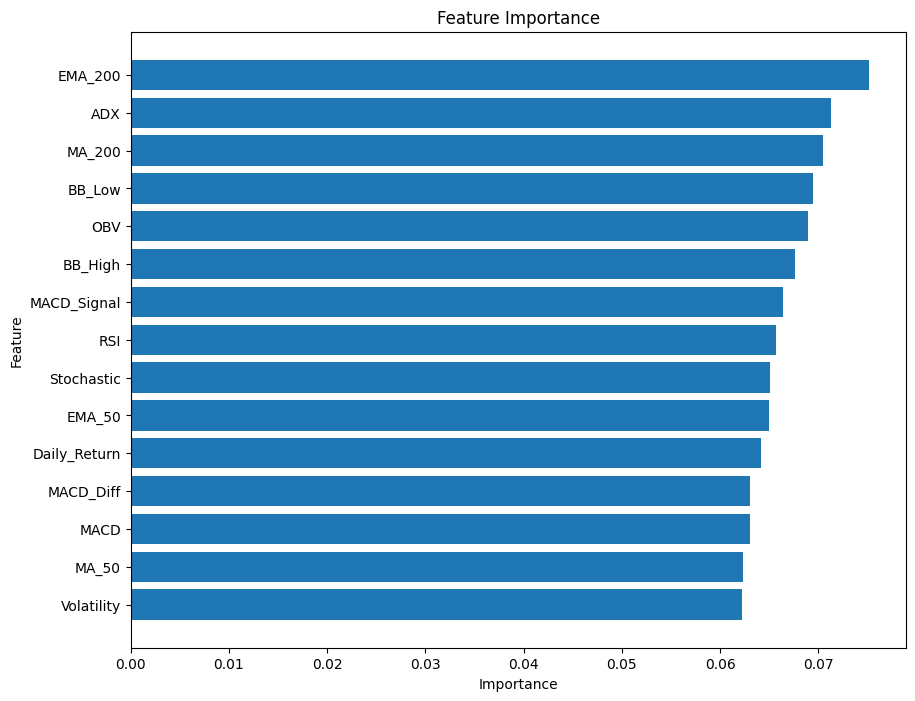

In [312]:
# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

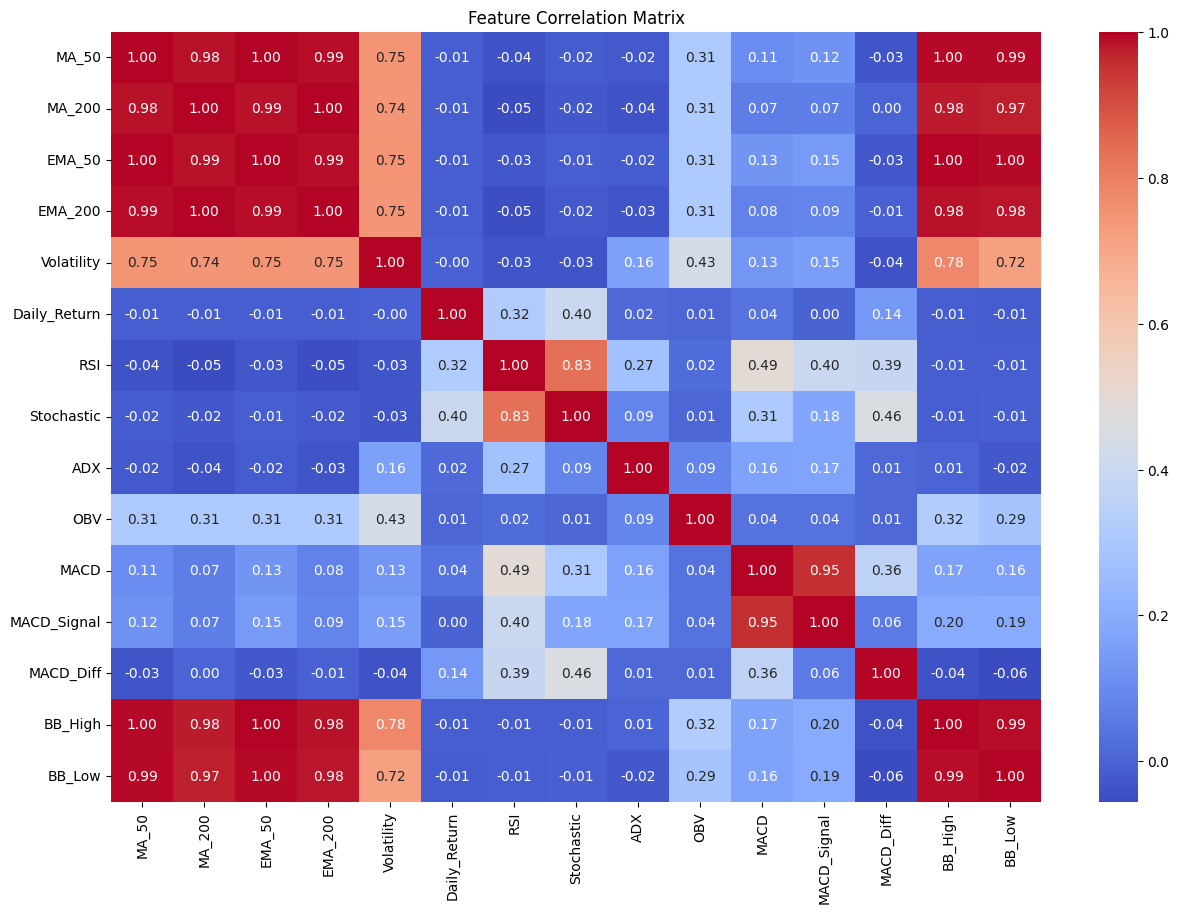

In [317]:
correlation_matrix = X.corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

[*********************100%%**********************]  1 of 1 completed
